In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import fisher_exact

In [21]:
# Load the datasets
case_data = pd.read_csv('PC_case.csv')
control_data = pd.read_csv('PC_control.csv')
gene_data = pd.read_csv('geneList.csv')

# Rename columns for clarity
case_data.columns = ['Chromosome', 'Start', 'End', 'Type', 'Patient_ID']
control_data.columns = ['Chromosome', 'Start', 'End', 'Type', 'Patient_ID']
gene_data.columns = ['Gene_ID', 'Unused', 'Chromosome', 'Gene_Start', 'Gene_End']

# Drop unused column in gene_list
gene_list = gene_data.drop(columns=['Unused'])

# Add a label column to distinguish between cases and controls
case_data['Label'] = 1
control_data['Label'] = 0

# Combine the datasets
data = pd.concat([case_data, control_data], ignore_index=True)

# Feature engineering: Extract key features
data['Length'] = data['End'] - data['Start']  # Length of the CNV

# Encode categorical variables (e.g., Type)
data = pd.get_dummies(data, columns=['Type'], drop_first=True)

# Convert non-numeric columns to numeric values
# Chromosome should be treated as categorical
data['Chromosome'] = data['Chromosome'].astype(str)  # Ensure Chromosome is a string
data['Chromosome'] = pd.factorize(data['Chromosome'])[0]  # Encode as numeric

# Re-select features and target after encoding
X = data[['Chromosome', 'Start', 'End', 'Length'] + [col for col in data.columns if 'Type' in col]]
y = data['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.98136998750426
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      6475
           1       0.97      0.96      0.96      2328

    accuracy                           0.98      8803
   macro avg       0.98      0.97      0.98      8803
weighted avg       0.98      0.98      0.98      8803



# Statistics

In [24]:
# Chromosomal Region Analysis
# Calculate frequency of CNVs per region in cases and controls
data['Region'] = data['Chromosome'].astype(str) + ":" + data['Start'].astype(str) + "-" + data['End'].astype(str)
region_stats = data.groupby(['Region', 'Label']).size().unstack(fill_value=0)
region_stats.columns = ['Control_Count', 'Case_Count']
region_stats['Total'] = region_stats['Control_Count'] + region_stats['Case_Count']
region_stats['Case_Frequency'] = region_stats['Case_Count'] / region_stats['Total']
region_stats['Control_Frequency'] = region_stats['Control_Count'] / region_stats['Total']

In [25]:
# Statistical significance using Fisher's Exact Test
def fisher_test(row):
    table = [[row['Case_Count'], row['Control_Count']],
             [region_stats['Case_Count'].sum() - row['Case_Count'],
              region_stats['Control_Count'].sum() - row['Control_Count']]]
    _, p_value = fisher_exact(table)
    return p_value

In [26]:
region_stats['P_Value'] = region_stats.apply(fisher_test, axis=1)

In [27]:
# Filter significant regions (e.g., p-value < 0.05)
significant_regions = region_stats[region_stats['P_Value'] < 0.05]

In [28]:
# Map Significant Regions to Genes
def map_to_genes(cnv_data, genes):
    cnv_data['Gene'] = None
    for index, row in cnv_data.iterrows():
        chrom, start, end = row.name.split(':')[0], int(row.name.split(':')[1].split('-')[0]), int(row.name.split(':')[1].split('-')[1])
        overlapping_genes = genes[(genes['Gene_Start'] <= end) & (genes['Gene_End'] >= start) & (genes['Chromosome'] == int(chrom))]
        cnv_data.at[index, 'Gene'] = ','.join(overlapping_genes['Gene_ID'].unique())
    return cnv_data

significant_regions_with_genes = map_to_genes(significant_regions, gene_list)

<ipython-input-28-06bc1b0a0dad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnv_data['Gene'] = None


In [29]:
# Save results
significant_regions_with_genes.to_csv('significant_regions_with_genes.csv', index=False)
print("Analysis complete. Results saved to 'significant_regions_with_genes.csv'.")

Analysis complete. Results saved to 'significant_regions_with_genes.csv'.


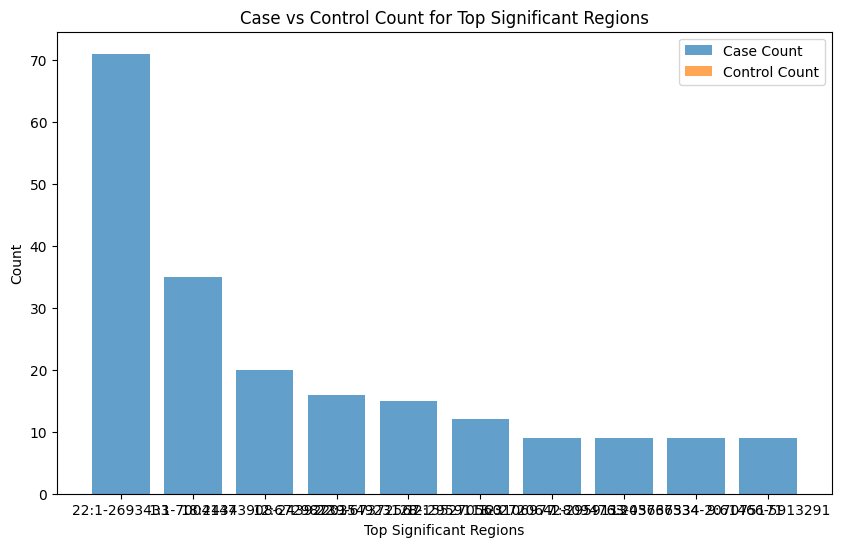

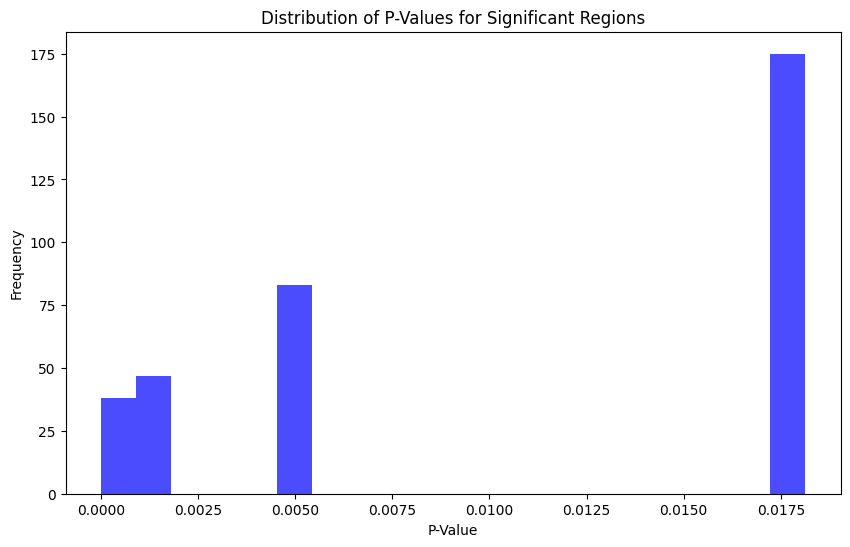

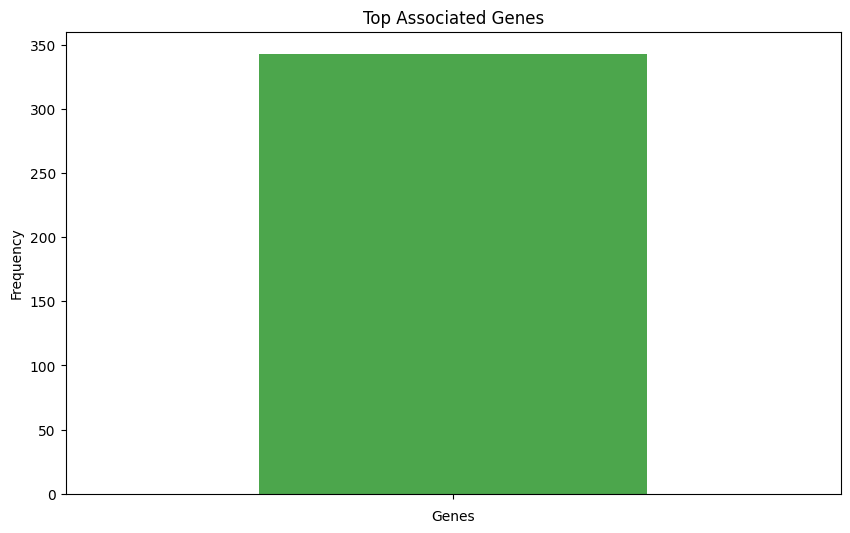

In [30]:
import matplotlib.pyplot as plt

# Bar plot: Compare Case_Count and Control_Count for top significant regions
top_regions = significant_regions.nlargest(10, 'Case_Count')
plt.figure(figsize=(10, 6))
plt.bar(top_regions.index, top_regions['Case_Count'], label='Case Count', alpha=0.7)
plt.bar(top_regions.index, top_regions['Control_Count'], label='Control Count', alpha=0.7)
plt.xlabel('Top Significant Regions')
plt.ylabel('Count')
plt.title('Case vs Control Count for Top Significant Regions')
plt.legend()
plt.show()

# Histogram: Distribution of P-Values
plt.figure(figsize=(10, 6))
plt.hist(significant_regions['P_Value'], bins=20, color='blue', alpha=0.7)
plt.xlabel('P-Value')
plt.ylabel('Frequency')
plt.title('Distribution of P-Values for Significant Regions')
plt.show()

# Gene Frequency: Count the most associated genes
if 'Gene' in significant_regions.columns:
    gene_counts = significant_regions['Gene'].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    gene_counts.plot(kind='bar', color='green', alpha=0.7)
    plt.xlabel('Genes')
    plt.ylabel('Frequency')
    plt.title('Top Associated Genes')
    plt.show()
else:
    print("No gene information available in the dataset.")